# Credit Card Fraud Detection
## Notebook 2: Data Preprocessing & Modeling

---

### Tujuan Notebook

1. Melakukan preprocessing data (scaling, splitting)
2. Menangani class imbalance dengan berbagai teknik
3. Melatih beberapa model machine learning
4. Mengevaluasi performa model dengan metrik yang tepat
5. Memilih model terbaik untuk deployment

### Catatan dari EDA

- Class imbalance sangat ekstrem (577:1)
- Tidak ada missing values
- Fitur `Amount` perlu di-scaling
- Fitur V17, V14, V12, V2, V4, V11 paling berpengaruh

---

## 1. Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)

# Utilities
import warnings
warnings.filterwarnings('ignore')

print("Libraries berhasil di-import")

Libraries berhasil di-import


## 2. Load Dataset

In [3]:
# Load dataset
df = pd.read_csv('../data/creditcard.csv')

print(f"Dataset shape: {df.shape}")
print(f"Fraud ratio: {df['Class'].mean()*100:.3f}%")

Dataset shape: (284807, 31)
Fraud ratio: 0.173%


## 3. Data Preprocessing

### 3.1 Feature Scaling

Fitur `Amount` dan `Time` memiliki skala yang berbeda dengan fitur V1-V28 (yang sudah di-PCA). Perlu dilakukan standardization agar semua fitur memiliki skala yang sama.

In [4]:
# Scaling Amount dan Time
scaler = StandardScaler()

df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_scaled'] = scaler.fit_transform(df[['Time']])

# Drop kolom original
df_processed = df.drop(['Amount', 'Time'], axis=1)

print("Sebelum scaling:")
print(f"  Amount range: {df['Amount'].min():.2f} - {df['Amount'].max():.2f}")
print(f"  Time range: {df['Time'].min():.2f} - {df['Time'].max():.2f}")

print("\nSetelah scaling:")
print(f"  Amount_scaled range: {df_processed['Amount_scaled'].min():.2f} - {df_processed['Amount_scaled'].max():.2f}")
print(f"  Time_scaled range: {df_processed['Time_scaled'].min():.2f} - {df_processed['Time_scaled'].max():.2f}")

Sebelum scaling:
  Amount range: 0.00 - 25691.16
  Time range: 0.00 - 172792.00

Setelah scaling:
  Amount_scaled range: -0.35 - 102.36
  Time_scaled range: -2.00 - 1.64


### 3.2 Split Data

Membagi data menjadi training set (80%) dan testing set (20%). Testing set tidak akan disentuh sampai evaluasi akhir.

In [5]:
# Pisahkan features dan target
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Memastikan proporsi fraud sama di train dan test
)

print("Data splitting:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Testing set: {X_test.shape[0]:,} samples")
print(f"\nProporsi fraud:")
print(f"  Training: {y_train.mean()*100:.3f}%")
print(f"  Testing: {y_test.mean()*100:.3f}%")

Data splitting:
  Training set: 227,845 samples
  Testing set: 56,962 samples

Proporsi fraud:
  Training: 0.173%
  Testing: 0.172%


## 4. Handling Class Imbalance

Dengan rasio 577:1, perlu strategi khusus untuk menangani class imbalance. Beberapa pendekatan yang akan digunakan:

| Teknik | Deskripsi |
|--------|-----------|
| Baseline | Tanpa handling, sebagai pembanding |
| Class Weight | Memberikan bobot lebih tinggi pada class minoritas |
| SMOTE | Membuat data sintetis untuk class minoritas |
| Undersampling | Mengurangi data class mayoritas |

### 4.1 Visualisasi Class Distribution

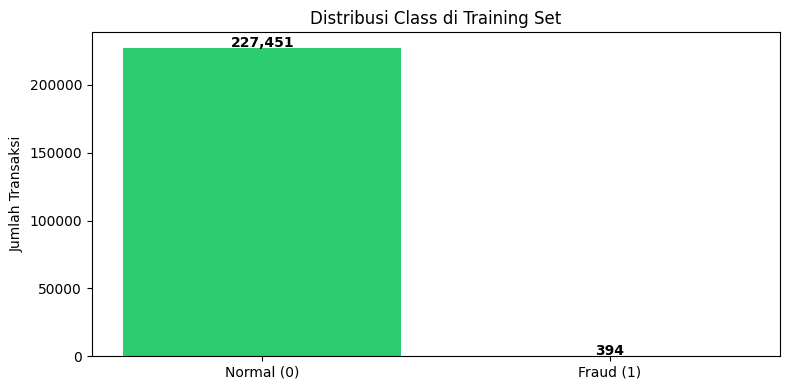

Rasio Normal:Fraud = 577:1


In [6]:
# Visualisasi distribusi class di training set
fig, ax = plt.subplots(figsize=(8, 4))

train_dist = y_train.value_counts()
ax.bar(['Normal (0)', 'Fraud (1)'], train_dist.values, color=['#2ecc71', '#e74c3c'])
ax.set_ylabel('Jumlah Transaksi')
ax.set_title('Distribusi Class di Training Set')

for i, v in enumerate(train_dist.values):
    ax.text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Rasio Normal:Fraud = {train_dist[0]//train_dist[1]}:1")

## 5. Fungsi Evaluasi

Membuat fungsi untuk evaluasi model. Karena class imbalance, metrik yang digunakan:

- **Precision**: Dari yang diprediksi fraud, berapa yang benar fraud
- **Recall**: Dari semua fraud, berapa yang berhasil ditangkap
- **F1-Score**: Harmonic mean dari precision dan recall
- **PR-AUC**: Area under Precision-Recall curve (lebih baik dari ROC-AUC untuk imbalanced data)

In [7]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Fungsi untuk mengevaluasi performa model
    """
    # Prediksi
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Print results
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"PR-AUC:    {pr_auc:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Confusion Matrix Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Normal', 'Fraud'],
                yticklabels=['Normal', 'Fraud'])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title(f'Confusion Matrix - {model_name}')
    
    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    axes[1].plot(rec, prec, color='#e74c3c', linewidth=2)
    axes[1].fill_between(rec, prec, alpha=0.3, color='#e74c3c')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'Precision-Recall Curve (AUC={pr_auc:.4f})')
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model_name': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc
    }

## 6. Training Model

Akan dilatih 3 model dengan beberapa pendekatan handling imbalance:

1. **Logistic Regression** - Baseline model, cepat dan interpretable
2. **Random Forest** - Ensemble model, robust terhadap outlier
3. **XGBoost** - Gradient boosting, biasanya performa terbaik untuk tabular data

### 6.1 Logistic Regression


Model: Logistic Regression (Baseline)
Precision: 0.8289
Recall:    0.6429
F1-Score:  0.7241
PR-AUC:    0.7439
ROC-AUC:   0.9573


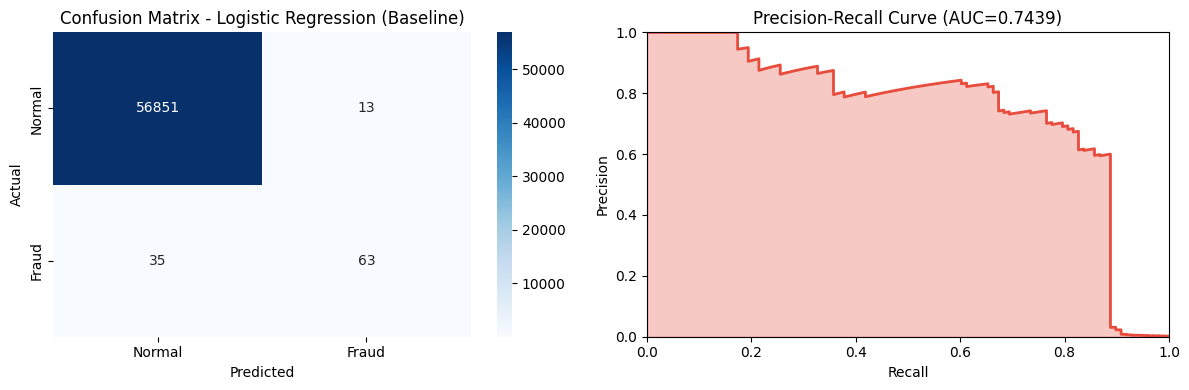

In [8]:
# Logistic Regression - Baseline (tanpa handling imbalance)
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train, y_train)

lr_baseline_results = evaluate_model(lr_baseline, X_test, y_test, "Logistic Regression (Baseline)")


Model: Logistic Regression (Class Weight)
Precision: 0.0609
Recall:    0.9184
F1-Score:  0.1141
PR-AUC:    0.7189
ROC-AUC:   0.9722


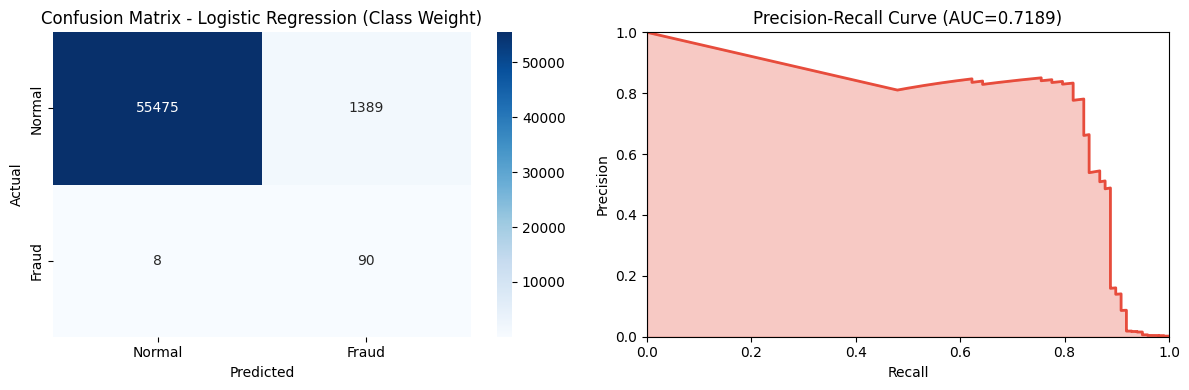

In [9]:
# Logistic Regression - dengan Class Weight
lr_weighted = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_weighted.fit(X_train, y_train)

lr_weighted_results = evaluate_model(lr_weighted, X_test, y_test, "Logistic Regression (Class Weight)")

### 6.2 Random Forest


Model: Random Forest (Baseline)
Precision: 0.9412
Recall:    0.8163
F1-Score:  0.8743
PR-AUC:    0.8608
ROC-AUC:   0.9528


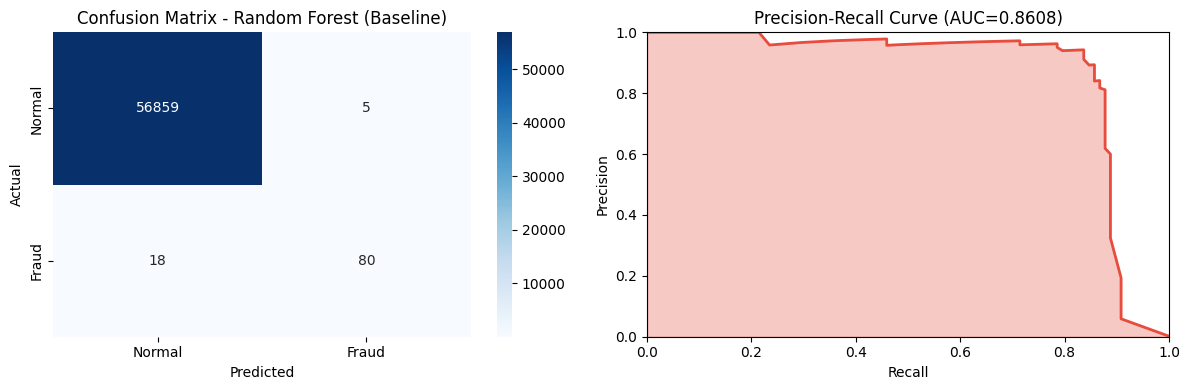

In [10]:
# Random Forest - Baseline
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

rf_baseline_results = evaluate_model(rf_baseline, X_test, y_test, "Random Forest (Baseline)")


Model: Random Forest (Class Weight)
Precision: 0.9610
Recall:    0.7551
F1-Score:  0.8457
PR-AUC:    0.8653
ROC-AUC:   0.9581


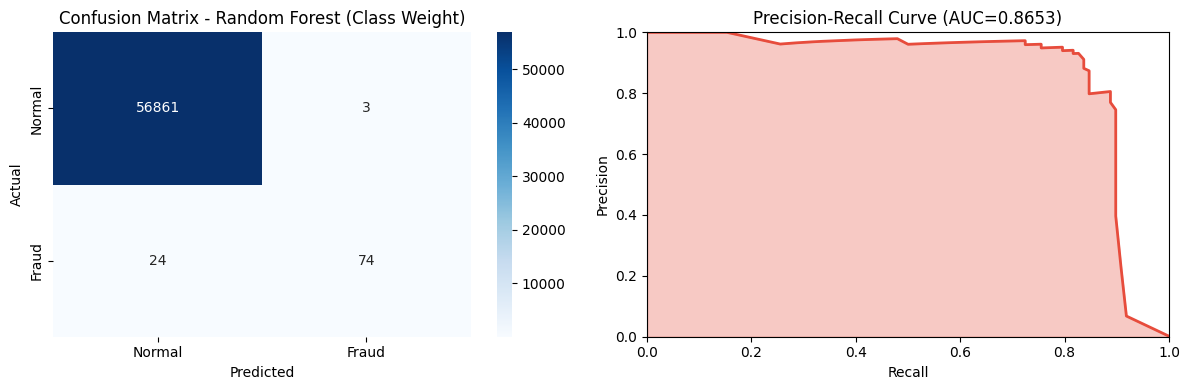

In [11]:
# Random Forest - dengan Class Weight
rf_weighted = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_weighted.fit(X_train, y_train)

rf_weighted_results = evaluate_model(rf_weighted, X_test, y_test, "Random Forest (Class Weight)")

### 6.3 XGBoost


Model: XGBoost (Baseline)
Precision: 0.9186
Recall:    0.8061
F1-Score:  0.8587
PR-AUC:    0.8777
ROC-AUC:   0.9743


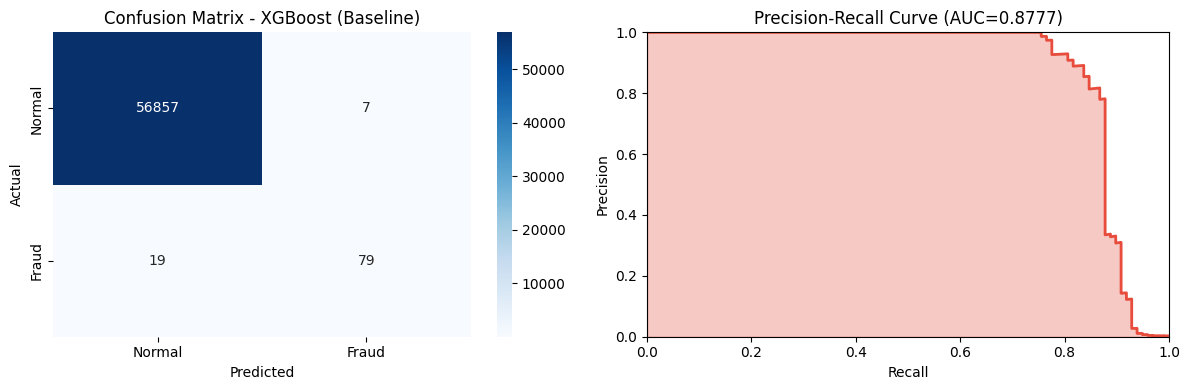

In [12]:
# XGBoost - Baseline
xgb_baseline = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_baseline.fit(X_train, y_train)

xgb_baseline_results = evaluate_model(xgb_baseline, X_test, y_test, "XGBoost (Baseline)")


Model: XGBoost (Scale Pos Weight)
Precision: 0.8830
Recall:    0.8469
F1-Score:  0.8646
PR-AUC:    0.8753
ROC-AUC:   0.9652


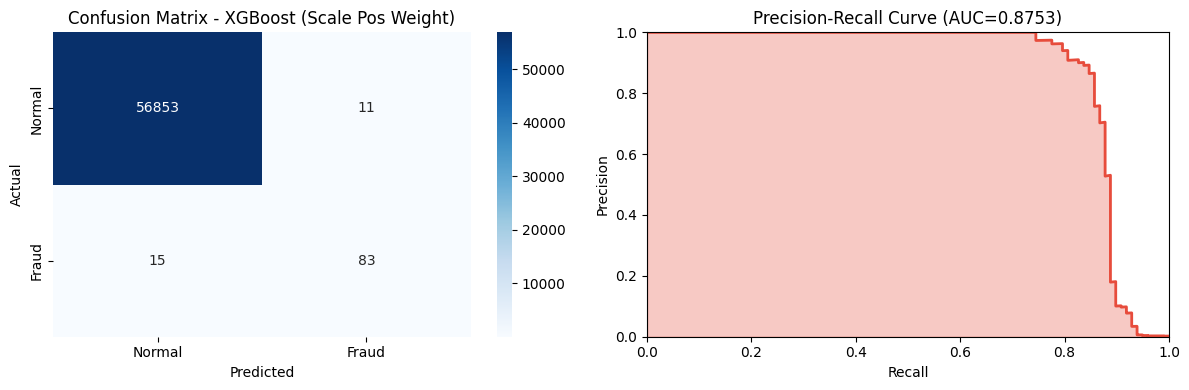

In [13]:
# Hitung scale_pos_weight (rasio negative/positive)
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

# XGBoost - dengan Scale Pos Weight
xgb_weighted = XGBClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1, 
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)
xgb_weighted.fit(X_train, y_train)

xgb_weighted_results = evaluate_model(xgb_weighted, X_test, y_test, "XGBoost (Scale Pos Weight)")

### 6.4 SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE membuat data sintetis untuk class minoritas dengan cara interpolasi antara data fraud yang sudah ada.

In [14]:
# Aplikasikan SMOTE pada training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:")
print(f"  Normal: {sum(y_train==0):,}")
print(f"  Fraud: {sum(y_train==1):,}")

print("\nSetelah SMOTE:")
print(f"  Normal: {sum(y_train_smote==0):,}")
print(f"  Fraud: {sum(y_train_smote==1):,}")

Sebelum SMOTE:
  Normal: 227,451
  Fraud: 394

Setelah SMOTE:
  Normal: 227,451
  Fraud: 227,451


In [15]:
# Aplikasikan SMOTE pada training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:")
print(f"  Normal: {sum(y_train==0):,}")
print(f"  Fraud: {sum(y_train==1):,}")

print("\nSetelah SMOTE:")
print(f"  Normal: {sum(y_train_smote==0):,}")
print(f"  Fraud: {sum(y_train_smote==1):,}")

Sebelum SMOTE:
  Normal: 227,451
  Fraud: 394

Setelah SMOTE:
  Normal: 227,451
  Fraud: 227,451



Model: XGBoost (SMOTE)
Precision: 0.7311
Recall:    0.8878
F1-Score:  0.8018
PR-AUC:    0.8774
ROC-AUC:   0.9792


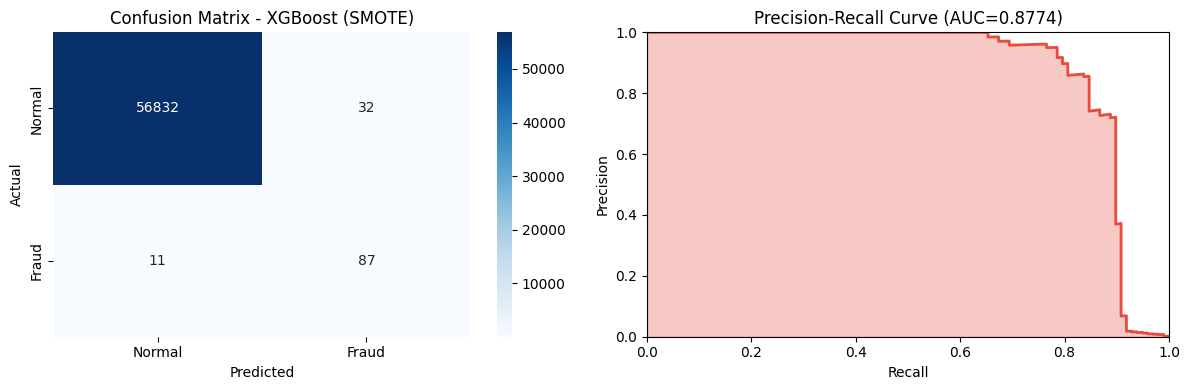

In [16]:
# XGBoost dengan SMOTE
xgb_smote = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_smote.fit(X_train_smote, y_train_smote)

xgb_smote_results = evaluate_model(xgb_smote, X_test, y_test, "XGBoost (SMOTE)")

## 7. Perbandingan Model

Membandingkan semua model yang sudah dilatih untuk memilih model terbaik.

In [17]:
# Kumpulkan semua hasil
all_results = [
    lr_baseline_results,
    lr_weighted_results,
    rf_baseline_results,
    rf_weighted_results,
    xgb_baseline_results,
    xgb_weighted_results,
    xgb_smote_results
]

# Buat dataframe perbandingan
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('f1', ascending=False)

print("Perbandingan Semua Model (diurutkan berdasarkan F1-Score):\n")
print(comparison_df.to_string(index=False))

Perbandingan Semua Model (diurutkan berdasarkan F1-Score):

                        model_name  precision   recall       f1   pr_auc  roc_auc
          Random Forest (Baseline)   0.941176 0.816327 0.874317 0.860751 0.952793
        XGBoost (Scale Pos Weight)   0.882979 0.846939 0.864583 0.875259 0.965221
                XGBoost (Baseline)   0.918605 0.806122 0.858696 0.877685 0.974323
      Random Forest (Class Weight)   0.961039 0.755102 0.845714 0.865297 0.958076
                   XGBoost (SMOTE)   0.731092 0.887755 0.801843 0.877425 0.979159
    Logistic Regression (Baseline)   0.828947 0.642857 0.724138 0.743949 0.957284
Logistic Regression (Class Weight)   0.060852 0.918367 0.114141 0.718946 0.972167


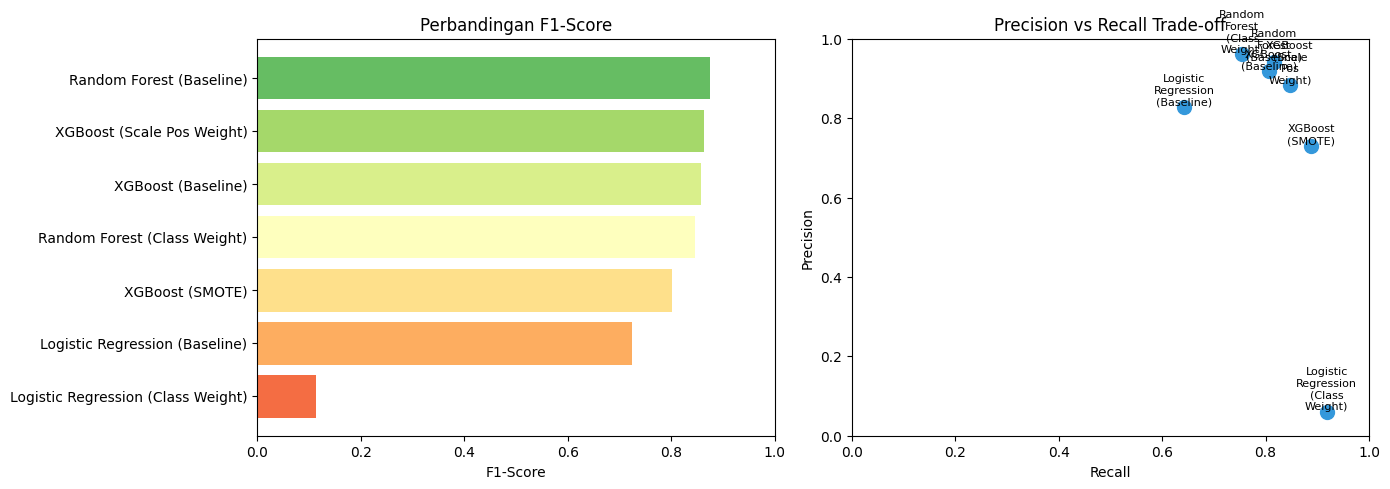

In [18]:
# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1-Score comparison
comparison_sorted = comparison_df.sort_values('f1', ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(comparison_sorted)))

axes[0].barh(comparison_sorted['model_name'], comparison_sorted['f1'], color=colors)
axes[0].set_xlabel('F1-Score')
axes[0].set_title('Perbandingan F1-Score')
axes[0].set_xlim(0, 1)

# Precision vs Recall
axes[1].scatter(comparison_df['recall'], comparison_df['precision'], s=100, c='#3498db')
for i, row in comparison_df.iterrows():
    axes[1].annotate(row['model_name'].replace(' ', '\n'), 
                     (row['recall'], row['precision']),
                     fontsize=8, ha='center', va='bottom')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision vs Recall Trade-off')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [19]:
# Model terbaik berdasarkan F1-Score
best_model_name = comparison_df.iloc[0]['model_name']
best_f1 = comparison_df.iloc[0]['f1']
best_recall = comparison_df.iloc[0]['recall']
best_precision = comparison_df.iloc[0]['precision']

print("=" * 50)
print("MODEL TERBAIK")
print("=" * 50)
print(f"Model: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")

MODEL TERBAIK
Model: Random Forest (Baseline)
F1-Score: 0.8743
Precision: 0.9412
Recall: 0.8163


## 8. Menyimpan Visualisasi

Menyimpan semua grafik hasil evaluasi ke folder `figures/` untuk dokumentasi.

In [23]:
import os

# Buat folder figures jika belum ada
figures_dir = '../figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Folder '{figures_dir}' berhasil dibuat")
else:
    print(f"Folder '{figures_dir}' sudah ada")

Folder '../figures' berhasil dibuat


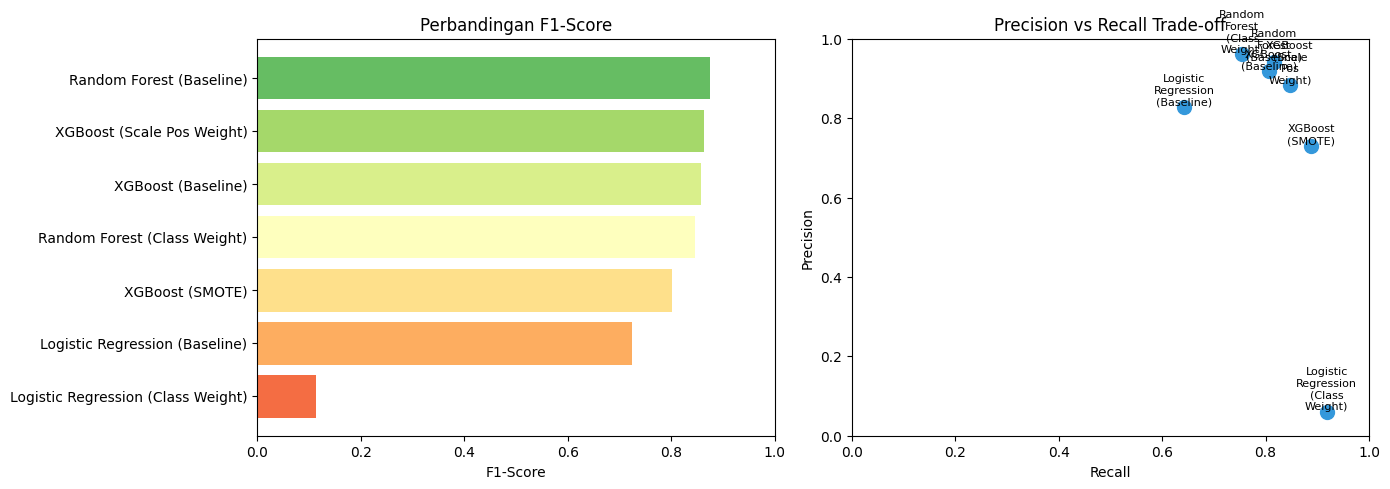

Grafik disimpan: ../figures/model_comparison.png


In [24]:
# Simpan grafik perbandingan model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1-Score comparison
comparison_sorted = comparison_df.sort_values('f1', ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(comparison_sorted)))

axes[0].barh(comparison_sorted['model_name'], comparison_sorted['f1'], color=colors)
axes[0].set_xlabel('F1-Score')
axes[0].set_title('Perbandingan F1-Score')
axes[0].set_xlim(0, 1)

# Precision vs Recall
axes[1].scatter(comparison_df['recall'], comparison_df['precision'], s=100, c='#3498db')
for i, row in comparison_df.iterrows():
    axes[1].annotate(row['model_name'].replace(' ', '\n'), 
                     (row['recall'], row['precision']),
                     fontsize=8, ha='center', va='bottom')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision vs Recall Trade-off')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(f'{figures_dir}/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Grafik disimpan: {figures_dir}/model_comparison.png")

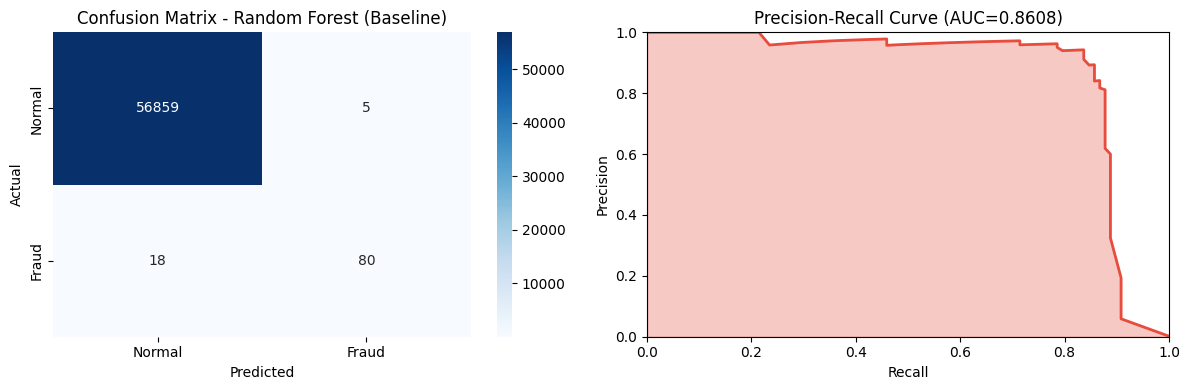

Grafik disimpan: ../figures/best_model_evaluation.png


In [25]:
# Simpan confusion matrix untuk model terbaik (Random Forest Baseline)
y_pred_best = rf_baseline.predict(X_test)
y_prob_best = rf_baseline.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Random Forest (Baseline)')

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob_best)
pr_auc = average_precision_score(y_test, y_prob_best)
axes[1].plot(rec, prec, color='#e74c3c', linewidth=2)
axes[1].fill_between(rec, prec, alpha=0.3, color='#e74c3c')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title(f'Precision-Recall Curve (AUC={pr_auc:.4f})')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(f'{figures_dir}/best_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Grafik disimpan: {figures_dir}/best_model_evaluation.png")

In [28]:
# Simpan hasil perbandingan ke CSV
comparison_df.to_csv(f'{figures_dir}/model_comparison.csv', index=False)
print(f"Hasil perbandingan disimpan: {figures_dir}/model_comparison.csv")

Hasil perbandingan disimpan: ../figures/model_comparison.csv
